In [1]:
%matplotlib inline
import matplotlib
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh
from discretize.utils import mesh_builder_xyz

from SimPEG.potential_fields import magnetics
from SimPEG import dask
from SimPEG.utils import plot2Ddata, surface2ind_topo
from SimPEG import (
    maps,
    data,
    inverse_problem,
    data_misfit,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
import pandas as pd
from ipywidgets import widgets, interact


In [5]:
import pandas as pd
from ipywidgets import widgets, interact


df = pd.read_excel(r"C:\Users\user\Documents\Paper Panjshir\Panjshir TMI and RTP for modeling.xlsx")
# Down sample the data
mpl.rcParams['font.size'] = 14
nskip = 30
receiver_locations = df[['Easting', 'Northing', 'Elevation']].values[::nskip,:]
xyz_topo = np.c_[receiver_locations[:,:2], np.zeros(receiver_locations.shape[0])]
dobs = df['RTP'].values[::nskip]

In [6]:
import pandas as pd
model = pd.read_csv('Pcop Mag susceptibility Model')
susceptibility_model = model["susceptibility"]
from discretize import TensorMesh
from discretize.utils import mesh_builder_xyz
dx = 80
dy = 80
dz = 80
depth_core = 1500
padding_distance_x_left = 1000
padding_distance_x_right = 1000
padding_distance_y_left = 1000
padding_distance_y_right= 1000
padding_distance_z_lower = 1000
padding_distance_z_upper = 0
xyz_topo =  receiver_locations
mesh = mesh_builder_xyz(
    xyz=xyz_topo, 
    h=[dx, dy, dz], 
    depth_core=depth_core, 
    padding_distance=[
        [padding_distance_x_left, padding_distance_x_right], 
        [padding_distance_y_left, padding_distance_y_right], 
        [padding_distance_z_lower, padding_distance_z_upper]
    ]
)
from discretize.utils import ExtractCoreMesh
zmin, zmax = -500, 0
ymin, ymax = receiver_locations[:,1].min(), receiver_locations[:,1].max()
xmin, xmax = receiver_locations[:,0].min(), receiver_locations[:,0].max()
xyzlim = np.array([[xmin, xmax],[ymin, ymax], [zmin, zmax]])
inds_core, mesh_core = ExtractCoreMesh(xyzlim, mesh)

C:\Users\user\anaconda3\lib\site-packages\pyvista\plotting\_plotting.py:280: PyVistaDeprecationWarning: 
"stitle" is a deprecated keyword argument and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyVistaDeprecationWarning)
C:\Users\user\anaconda3\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


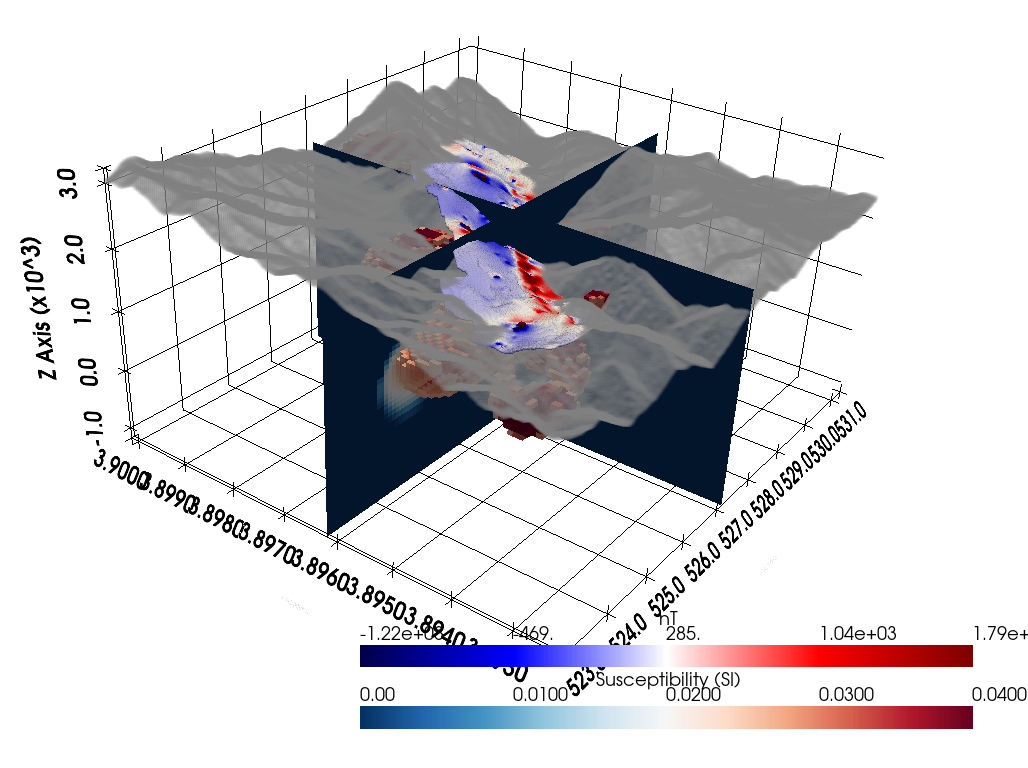

In [7]:
#import topography as downloded DEM
topography = pd.read_csv('topography clipped study area')
#transfrom the topography from csv to array data
topography = topography[['X_coord', 'Y_coord', 'Elevation']].values[::1,:]
# extract the magnetic data as array from dataset
rtp = df[['Easting', 'Northing', 'RTP']].values[::1,:]
rtp_data = rtp[:, 2]
#specify the magnetic data points coordinates
mag_points = df[['Easting', 'Northing', 'Elevation']].values[::1,:]
import pyvista as pv
#create PolyData to map the magnetic data over the recovered model
cloud = pv.wrap(mag_points)
def plot_3d_with_pyvista(model, notebook=True, threshold=0.04):
    pv.set_plot_theme("document")
    # Get the PyVista dataset of the inverted model
    dataset = mesh.to_vtk({'susceptibility':model})
    # Create the rendering scene
    p = pv.Plotter(notebook=notebook)
    # add a grid axes
    p.show_grid()
    # Extract volumetric threshold
    threshed = dataset.threshold(threshold, invert=False)
    # Add spatially referenced data to the scene
    dparams = dict(
        show_edges=False,
        cmap="RdBu_r",
        clim=[0, 0.04],
        stitle='Susceptibility (SI)', 
    )
    
    p.add_mesh(threshed, **dparams)
    # Add spatially referenced data to the scene
    p.add_mesh(dataset.slice("x"), **dparams)
    p.add_mesh(dataset.slice("y"), **dparams)
    p.add_mesh(
        topography, opacity=0.050, color="grey",)
    p.add_mesh(cloud,
               scalars=rtp_data,
               cmap="seismic",
               point_size=3, render_points_as_spheres=True,
              stitle='nT', clim=(vmin-5, vmax+5),)
    p.set_scale(1,1,1)
    cpos = [(511000.67,  3885221.37, 11000),
     (533357.93, 3900154.63, -5000),
     (0.4274014723619113, 0.35262874486945933, 0.8324547733749025)]
    p.camera_position = cpos
    p.show(window_size=[1028, 768])
plot_3d_with_pyvista(susceptibility_model, notebook=True, threshold=0.026)